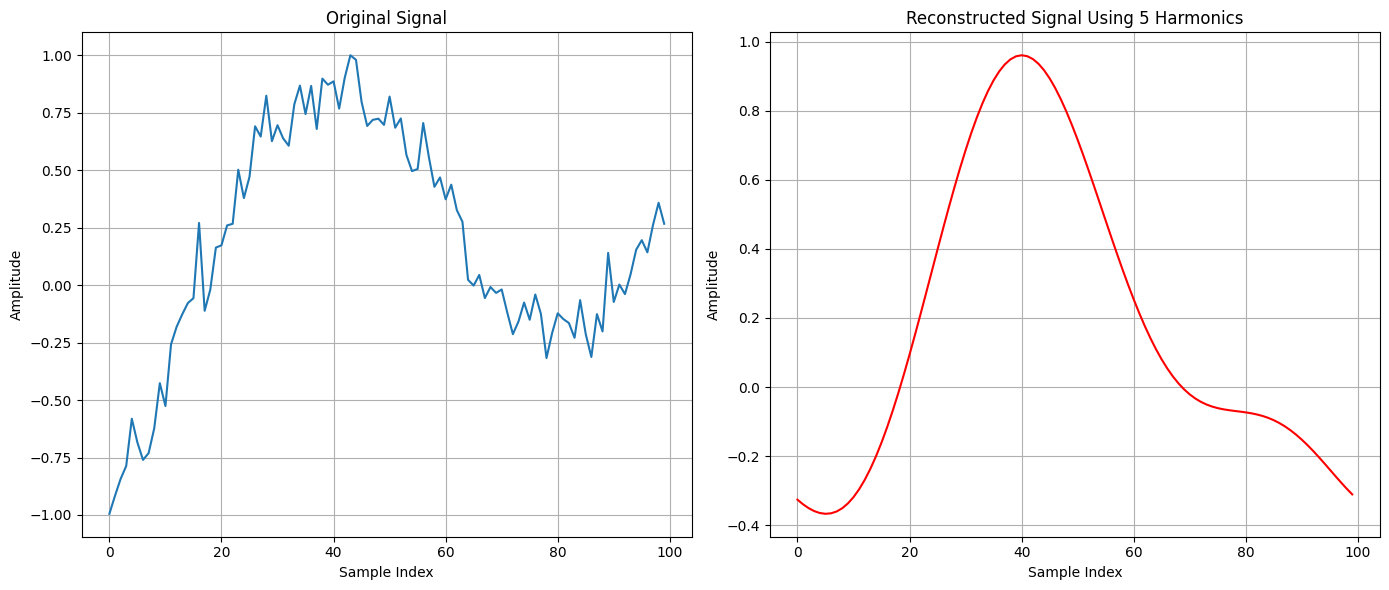

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def generate_signal(num_samples=100):
    """
    :param num_samples: Total number of samples in the signal
    :return: 
    """
    num_periods = np.random.randint(3, 7)  # Randomly choose how many periods to combine
    periods = np.random.randint(2, 1200, num_periods)  # Period lengths in samples
    phases = np.random.rand(num_periods) * 2 * np.pi

    # Generate random amplitudes and normalize them to sum to 1
    amplitudes = np.random.rand(num_periods)
    amplitudes /= np.sum(amplitudes)

    # Sample indices
    samples = np.arange(num_samples)

    # Generate a random continuous periodic signal
    signal = sum(amplitude * np.sin(2 * np.pi * (1 / period) * samples + phase) for amplitude, period, phase in zip(amplitudes, periods, phases))
    signal = signal / np.max(np.abs(signal))  # Normalize signal

    # Add random noise to the signal
    noise = np.random.normal(0, 0.1, signal.shape)
    signal += noise
    signal = signal / np.max(np.abs(signal))  # Normalize signal again

    return samples, signal

# Function to reconstruct the signal using the 5 most relevant harmonics
def reconstruct_signal(signal):
    fft_result = torch.fft.fft(signal)
    # Find indices of the 5 largest amplitudes in the FFT result
    _, indices = torch.topk(torch.abs(fft_result), 5)
    
    # Initialize a tensor for the reconstructed signal
    num_samples = signal.size(0)
    reconstructed_signal = torch.zeros(num_samples, dtype=torch.complex64)
    for index in indices:
        amplitude = torch.abs(fft_result[index]) / num_samples
        phase = torch.angle(fft_result[index])
        # Accumulate the selected harmonics
        reconstructed_signal += amplitude * torch.exp(1j * (2 * torch.pi * index * torch.arange(num_samples) / num_samples + phase))
    
    # Return the real part of the reconstructed signal
    return reconstructed_signal.real

# Main
num_samples = 100  # Specify the number of samples here
_, signal = generate_signal(num_samples)
signal = torch.from_numpy(signal)
reconstructed_signal = reconstruct_signal(signal)

# Plotting
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(signal.numpy(), label='Original Signal')
plt.title('Original Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(reconstructed_signal.numpy(), label='Reconstructed Signal', color='red')
plt.title('Reconstructed Signal Using 5 Harmonics')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()